# Import Packages

In [1]:
import numpy as np
import heapq
import matplotlib.pyplot as plt
import pandas as pd
import random
import time

# Reading Data

In [2]:
df = pd.read_csv("data.csv")

# Constructing Customer Class and Functions

In [3]:
class SimData:
    '''
    SimData->Refer to the code provided by the Lab4_Data7202
    Contain the information for each customer
    '''
    def __init__(self,time_arrive, event_type, serv_1_start, serv_1_end,serv_length,serv_number):
        self.time_arrive = time_arrive
        self.event_type = event_type
        self.serv_1_start = serv_1_start
        self.serv_1_end = serv_1_end
        self.serv_length = serv_length
        self.serv_number = serv_number
        
    def Print(self):
        print(self.m_time_arrive," (", self.m_event_type,  ") : "
              ", ",self.m_serv_1_start, " - ", self.m_serv_1_end)
        print("service length:", self.m_serv_length)
        
def FindVacantDesk(State):
    '''
    Input State List
    Out put the index of the State List which state is 0
    '''
    Slist = []
    for s in range(len(State)):
        if State[s]<1:
            Slist.append(s)
    return Slist

def FindShortestDesk(Q):
    '''
    Input Queue
    Output a list of index refer to the elements in Queue which has the shortest length
    '''
    shortValue = 99999999 
    shortList = []
    for q in Q:
        if len(q) < shortValue:
            shortValue = len(q)
    for i, q in enumerate(Q):
        if len(q) == shortValue:
            shortList.append(i)
    #return shortList
    random_queue = random.choice(shortList)
    return random_queue
    

#Testing
#FindShortestDesk([[1,2,3,4,5,5],[2,3,3],[2,],[5,]])
#x = FindVacantDesk([1,0,1,0,0,1])
#random.choice(x)

# Simulation Code

In [4]:
def simulation(n):
    #record list
    time_arr = []
    ellqx_len = []

    T = 3000 # simulation time
    ell = []
    priorityQueue = []
    Queue = []
    ServiceState = []
    N_Desk = n #Number of service desk to open
    for i in range(N_Desk):
        Queue.append([])
        ServiceState.append(0)
        
        
    # create first arrival
    arrival, service = df.sample(n=1).iloc[0]
    t_current = arrival
    # Initializing customer
    data = SimData(t_current,"ARRIVAL",-1,-1,service,-1)
    #put it in priorityQueue by using heapq
    heapq.heappush(priorityQueue,(t_current,random.random(),data))
    
    
    #start = time.time()
    while(t_current<T):
        #pop a object from priorityQueue which has the closest arrival time
        obj = heapq.heappop(priorityQueue)
        t_current = obj[0]
        event = obj[2]

        # record queus length
        time_arr.append(t_current)
        q_length = [] 
        for i in range(N_Desk):
            q_length.append(len(Queue[i]))
        ellqx_len.append(q_length)

        if(event.event_type == "ARRIVAL" and event.serv_number<0):
            # handle arrival
            # schedule the next arrival
            next_arrival, next_service = df.sample(n=1).iloc[0]
            t_next = t_current + next_arrival
            data = SimData(t_next,"ARRIVAL",-1,-1,next_service,-1)
            heapq.heappush(priorityQueue,(t_next,random.random(),data))

            vacant_list = FindVacantDesk(ServiceState)
            if len(vacant_list)>0.9:
                #random select a random_queue
                random_queue = random.choice(vacant_list) #Index of the Queue
                #Update the chosen queue
                ServiceState[random_queue] = 1
                #Update the start time, end time, customer state, the number of Queue the customer in
                event.serv_1_start = t_current
                event.serv_1_end = t_current + event.serv_length
                event.event_type = "DEPARTURE_SERV1"
                event.serv_number = random_queue
                #Add it into priorityQueue
                heapq.heappush(priorityQueue,(event.serv_1_end,random.random(),event))
            else:
                # We asign to the smallest list
                random_queue = FindShortestDesk(Queue) #Index of the Queue
                #Add the customer to the corresponding Queue
                event.serv_number = random_queue
                Queue[random_queue].append(event)
            continue

        if(event.event_type == "DEPARTURE_SERV1"):
            ell.append(event)
            # Set the corresponding queue to be vacant
            ServiceState[event.serv_number] = 0
            if len(Queue[event.serv_number])!=0:
                obj_wait_inq1 = Queue[event.serv_number].pop(0)
                obj_wait_inq1.serv_1_start = t_current
                obj_wait_inq1.event_type = "DEPARTURE_SERV1"
                obj_wait_inq1.serv_1_end = t_current + obj_wait_inq1.serv_length
                heapq.heappush(priorityQueue,(obj_wait_inq1.serv_1_end,random.random(),obj_wait_inq1))
                ServiceState[obj_wait_inq1.serv_number] = 1
            continue
    #end = time.time()
    #print('executing time: ', end-start)
    
    
    return ell,time_arr,ellqx_len

# 50 Batches analyzing

95% CI for total waiting time in the system ( 0.4408100698901716  ,  0.649174110235941 )


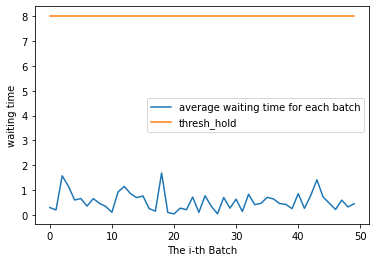

In [5]:
n = 8
ell,_,_ = simulation(n)

# Calculate the average waiting time in the system
BurnIn = int(len(ell)*0.3)
ell_w_time = np.zeros(len(ell)-BurnIn)

for i in range(0,len(ell)-BurnIn):
    event = ell[i+BurnIn]
    wait_t = event.serv_1_start - event.time_arrive
    ell_w_time[i] = wait_t

Batches = np.array_split(ell_w_time, 50)
B_Mean = [np.mean(b) for b in Batches]
B_List = [i for i in range(len(Batches))]
threshold_List = [8 for i in range(len(Batches))]

#tmean = np.mean(ell_w_time)

tmean = np.mean(B_Mean)
tstd = np.std(B_Mean)/np.sqrt(len(B_Mean))
print("95% CI for total waiting time in the system (", tmean - 1.96*tstd, " , ", tmean + 1.96*tstd, ")")


plt.plot( B_List,B_Mean, label="average waiting time for each batch")
plt.plot( B_List,threshold_List, label="thresh_hold")
plt.xlabel("The i-th Batch")
plt.ylabel("waiting time")
plt.legend()

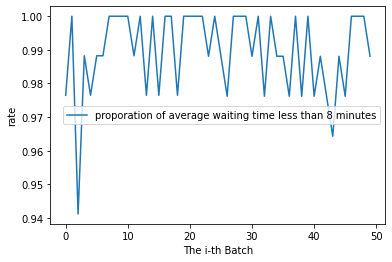

In [6]:
Wait = []
for b in Batches:
    n = len(b)
    count = len(['yes' for i in b if i< 8])
    Wait.append(count/n)
        
plt.plot( B_List,Wait, label="proporation of average waiting time less than 8 minutes")
plt.xlabel("The i-th Batch")
plt.ylabel("rate")
plt.legend()

# Analyzing without batches

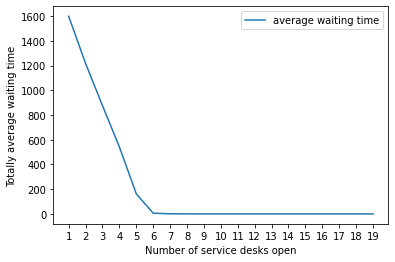

In [7]:
K = []
for n in range(1,20):
    ell,time_arr,ellqx_len = simulation(n)
    BurnIn = int(len(ell)*0.3)
    ell_w_time = np.zeros(len(ell)-BurnIn)
    ell_arr_time = np.zeros(len(ell)-BurnIn)
    
    for i in range(0,len(ell)-BurnIn):
        event = ell[i+BurnIn]
        wait_t = event.serv_1_start - event.time_arrive
        ell_w_time[i] = wait_t
        
    tmean = np.mean(ell_w_time)
    K.append(tmean)
        
plt.plot([str(i) for i in range(1,20)], K,label="average waiting time")
plt.xlabel('Number of service desks open')
plt.ylabel('Totally average waiting time')
plt.legend()

95% CI for total waiting time in the system ( 0.461327846333683  ,  0.5548225989780202 )


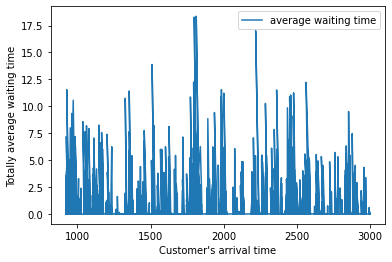

In [8]:
n = 8
ell,time_arr,ellqx_len = simulation(n)


# Calculate the average waiting time in the system
BurnIn = int(len(ell)*0.3)
ell_w_time = np.zeros(len(ell)-BurnIn)
ell_arr_time = np.zeros(len(ell)-BurnIn)

for i in range(0,len(ell)-BurnIn):
    event = ell[i+BurnIn]
    wait_t = event.serv_1_start - event.time_arrive
    ell_w_time[i] = wait_t
    ell_arr_time[i] = event.time_arrive

tmean = np.mean(ell_w_time)
tstd = np.std(ell_w_time)/np.sqrt(len(ell_w_time))

print("95% CI for total waiting time in the system (", tmean - 1.96*tstd, " , ", tmean + 1.96*tstd, ")")

plt.plot(ell_arr_time,ell_w_time, label="average waiting time")
plt.xlabel("Customer's arrival time")
plt.ylabel('Totally average waiting time')
plt.legend()

for  Queue_1 95% CI for waiting time in the system ( 0.372229624411453  ,  0.6581784687769286 )
for  Queue_2 95% CI for waiting time in the system ( 0.37481410477193583  ,  0.6425056317618956 )
for  Queue_3 95% CI for waiting time in the system ( 0.46343996416337796  ,  0.7393075894850036 )
for  Queue_4 95% CI for waiting time in the system ( 0.28862429835413517  ,  0.49391293250653245 )
for  Queue_5 95% CI for waiting time in the system ( 0.3334725930077568  ,  0.6063258456432828 )
for  Queue_6 95% CI for waiting time in the system ( 0.3451778459669812  ,  0.580202092277258 )
for  Queue_7 95% CI for waiting time in the system ( 0.41535305501191394  ,  0.6836934602759304 )
for  Queue_8 95% CI for waiting time in the system ( 0.4240795880023529  ,  0.7130895177427694 )


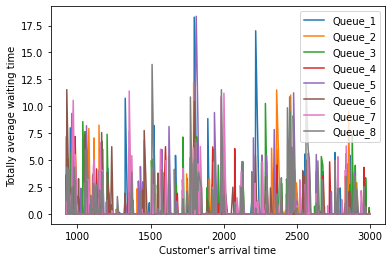

In [9]:
BurnIn = int(len(ell)*0.3)
for n in range(n):
    ell_arr_time = []
    ell_w_time = []
    name = "Queue_"+str(n+1)
    for i in range(BurnIn,len(ell)):
        event = ell[i]
        if event.serv_number == n:
            ell_arr_time.append(event.time_arrive)
            ell_w_time.append(event.serv_1_start-event.time_arrive)
            
    tmean = np.mean(ell_w_time)
    tstd = np.std(ell_w_time)/np.sqrt(len(ell_w_time))
    print("for ",name,"95% CI for waiting time in the system (", tmean - 1.96*tstd, " , ", tmean + 1.96*tstd, ")")
    plt.xlabel("Customer's arrival time")
    plt.ylabel('Totally average waiting time')
    plt.plot(ell_arr_time,ell_w_time, label=name)
plt.legend()

# Thank you for reading my code